# <a id='toc1_'></a>[1000 Words: Image Caption Generator](#toc0_)

Ananya Chattoraj

cananya53@gmail.com

**Table of contents**<a id='toc0_'></a>    
- [1000 Words: Image Caption Generator](#toc1_)    
  - [Notes](#toc1_1_)    
  - [Outputs](#toc1_2_)    
  - [Final Thoughts](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Notes](#toc0_)

This is the final notebook that has the preloaded best model and functions to generate captions. There is also a random image function that pulls a random image from the test folder to generate a caption. For details on the process, see the other notebooks in this project.

Packages

In [1]:
import numpy as np
from numpy import array, argmax
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetV2S
from keras.utils import load_img, img_to_array, to_categorical, pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, LSTM, Embedding, Add, Input, Bidirectional, Attention, GRU
from keras.callbacks import EarlyStopping
import os
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import pickle

Loading in all variables and functions

In [2]:
#information from pre-processing
imagefolder = 'flickr8k/images/'
imagesize = 224
batch_size = 15
max_length =29 #from preprocessing notebook
traindirectory = 'flickr8k/images/train'
testdirectory = 'flickr8k/images/test'
valdirectory = 'flickr8k/images/val'
with open('features.pkl', 'rb') as file:
    features = pickle.load(file)
with open('valfeatures.pkl', 'rb') as file:
    valfeatures = pickle.load(file)
with open('testfeatures.pkl', 'rb') as file:
    testfeatures = pickle.load(file)
with open('traindict.pkl', 'rb') as file:
    traindict = pickle.load(file)
with open('valdict.pkl', 'rb') as file:
    valdict = pickle.load(file)
with open('testdict.pkl', 'rb') as file:
    testdict = pickle.load(file)
train5_df = pd.read_pickle('train5df.pkl')
val5_df = pd.read_pickle('val5df.pkl')
test5_df = pd.read_pickle('test5df.pkl')

In [3]:
X5_train=pd.read_pickle('trainpics5.pkl')
X5_test=pd.read_pickle('testpics5.pkl')
X5_val=pd.read_pickle('valpics5.pkl')
y5_train=pd.read_pickle('traintokens5.pkl')
y5_test=pd.read_pickle('testtokens5.pkl')
y5_val=pd.read_pickle('valtokens5.pkl')

In [4]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(train5_df['merged_captions_blob'])
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size:  {vocab_size}')

Vocabulary Size:  3649


In [5]:
model = load_model('model13_all5.h5')

In [6]:
def actual_test_caption(image_filename, test5_df = test5_df):
    """
    Function: to retrieve the corresponding actual caption for a given filename.
    
    Parameters:
        image_filename (str): The filename for which to retrieve the actual caption. This image must be in the testdirectory.
        test_df (pandas.DataFrame): The test DataFrame containing the 'tokenized' and 'actual_caption' columns.
        
    Returns:
        str: The actual caption corresponding to the given filename.
        None: If the filename is not found in the DataFrame.
    """
    if image_filename in test5_df['image'].values:
        row = test5_df[test5_df['image'] == image_filename]
        actual_caption = row['caption1'].iloc[0]
        actual_caption = ' '.join(actual_caption.split())
        return actual_caption
    else:
        print(f"Filename '{image_filename}' not found in the DataFrame.")
        return None

In [7]:
def load_image(image_filename, imagesize = imagesize):
    """
    Function: to load an image and resize it from the test directory
    
    Parameters:
        image_filename (str): The filename for which to retrieve the actual caption.
        imagesize (int): The size to which the images should be resized.
        
    Returns:
        image: The image array by which to display the image.
    """
    testdirectory = 'flickr8k/images/test'
    image = []
    imgf = []
    if image_filename in testfeatures:
        imgfeat = testfeatures[image_filename]
        imgpath = os.path.join(testdirectory, image_filename)
        imgload = load_img(imgpath)
        imgresized = imgload.resize((imagesize, imagesize))
        imgarray = img_to_array(imgresized) / 255.
        image.append(imgarray)
        imgf.append(imgfeat)
    else:
        raise ValueError (f'Filename {image_filename} not found in test set')
    return image, imgf

In [8]:
def generate_caption(pred_model, feat, tokenizer = tokenizer, max_length = max_length):
    """
    Function: to generate a caption given an image input and a trained model
    
    Parameters:
        pred_model (keras model): A pretrained model ready to predict captions
        photo (list of array): Features of the photo to use in the model
        tokenizer (keras tokenizer): The tokenizer used to generate sequences
        max_length (int): The length of the longest actual caption
        
    Returns:
        captiontxt: The predicted caption of the image.
    """
    intxt = 'start'
    captiontxt = []
    #feat = array(feat)
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([intxt])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        probability_output = pred_model.predict([feat, sequence], verbose = 0)
        wordindex = argmax(probability_output)
        word = tokenizer.index_word[wordindex]
        if word is None:
            break
        intxt += ' ' + word
        if word !='end':
            captiontxt.append(word)
        if word =='end':
            break
    captiontxt = ' '.join(captiontxt)
    return captiontxt

In [9]:
def calculate_bleu_score(reference, candidate, max_ngram=4):
    """
    Function: Calculate BLEU scores for various n-grams between a reference and candidate sentence.
    
    Parameters:
        reference (str): The reference sentence (actual caption).
        candidate (str): The candidate sentence (generated caption).
        max_ngram (int): The maximum n-gram for BLEU calculation (default is 4).
        
    Returns:
        dict: A dictionary containing BLEU scores for 1 to max_ngram n-grams.
    """
    bleu_scores = {}
    reference_tokens = word_tokenize(reference.lower())
    candidate_tokens = word_tokenize(candidate.lower())

    smoothie = SmoothingFunction().method1
    
    for n in range(1, max_ngram + 1):
        weights = tuple(1.0 / n for _ in range(n))
        bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=weights, smoothing_function=smoothie)
        bleu_scores[f'BLEU-{n}'] = bleu_score
    # Note that scores 1 - 4 are returned along with the average, bleu 1 seems to be the most relevant for our purpose
    bleu_scores['Average BLEU'] = (bleu_scores['BLEU-1'] * bleu_scores['BLEU-2'] * bleu_scores['BLEU-3'] * bleu_scores['BLEU-4']) ** (1.0 / max_ngram)
    return bleu_scores

In [10]:
def test_output(image_filename,model, testdirectory = testdirectory, imagesize = imagesize, tokenizer = tokenizer, max_length = max_length):
    """
    Process an image using a given model to generate a caption and evaluate its accuracy.

    Parameters:
        image_filename (str): The filename of the image to be processed.
        model: The pre-trained model to generate the caption.
        testdirectory (str, optional): The directory where the test images are located.
            Defaults to the value of `testdirectory` variable.
        imagesize (int, optional): The size to which the image should be resized for processing.
            Defaults to the value of `imagesize` variable.
        tokenizer: The tokenizer used to tokenize the text sequences.
        max_length (int, optional): The maximum length of the generated caption.
            Defaults to the value of `max_length` variable.

    Returns:
        None: The function does not return any value, but it displays the results and the processed image.

    Notes:
        - The function processes the given image, generates a caption using the specified model,
          retrieves the actual caption from the test data, and calculates the BLEU scores for the generated caption.
        - The generated caption, actual caption, and BLEU scores are printed to the console.
        - The processed image is displayed using matplotlib.
    """
    image, imgf = load_image(image_filename, imagesize)
    # Generate the caption
    gencaption = generate_caption(model, imgf)
    # Retrieve the actual caption
    actualcaption = actual_test_caption(image_filename)
    # Calculate BLEU scores
    bleu_scores = calculate_bleu_score(actualcaption, gencaption)
    # Print results
    print(bleu_scores)
    print(f'generated caption: {gencaption}')
    print(f'actual caption: {actualcaption}')
    # Display the image
    plt.imshow(image[0])
    plt.show()

_______

## <a id='toc1_2_'></a>[Outputs](#toc0_)

{'BLEU-1': 0.14285714285714285, 'BLEU-2': 0.048795003647426664, 'BLEU-3': 0.036246012433429745, 'BLEU-4': 0.033031643180138064, 'Average BLEU': 0.05374857221646122}
generated caption: black dog is running in the grass
actual caption: dog chases stuffed animal attached to string


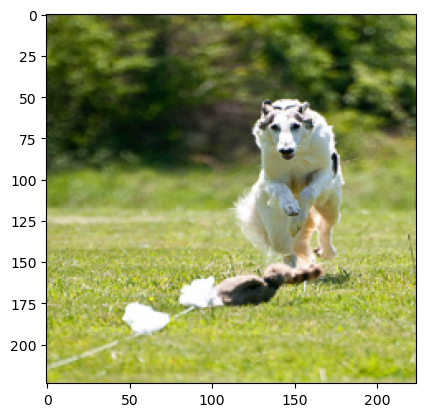

In [11]:
#dog image test
image_filename = '3540416981_4e74f08cbb.jpg'
test_output(image_filename,model)

{'BLEU-1': 0.16666666666666669, 'BLEU-2': 0.05773502691896258, 'BLEU-3': 0.043679023236814954, 'BLEU-4': 0.040824829046386304, 'Average BLEU': 0.0643607881521975}
generated caption: dog is running on the water
actual caption: brown dog races through field


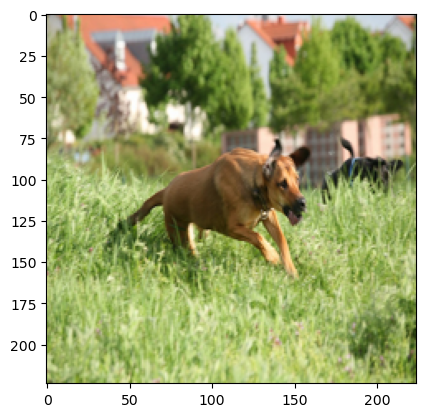

In [12]:
#this was the random image test
image_filename = '2460159430_71ab1aacfa.jpg'
test_output(image_filename,model)

In [ ]:
#random image and generated caption
testimagelist = test5_df['image'].tolist()
randomimage = random.sample(testimagelist, 1)
image_filename = str(randomimage[0])
test_output(image_filename,model)

## <a id='toc1_3_'></a>[Final Thoughts](#toc0_)

It is clear that using only 1200 images did not yield the best results in caption generation. In the future, I may rework this to include all images or try this with a niche dataset.